# Exploratory Data Analysis for r/AmItheAsshole (r/AITA)

This notebook covers the initial data exploration relating solely to r/AmItheAsshole in relation to our business goal of analyzing and predicting flair occurrences based on posts' text content.

In [2]:
# Setup - Run only once per Kernel App
%conda install openjdk -y

# install PySpark
%pip install pyspark==3.2.0

# restart kernel
from IPython.core.display import HTML
HTML("<script>Jupyter.notebook.kernel.restart()</script>")

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 23.3.1
  latest version: 23.10.0

Please update conda by running

    $ conda update -n base -c defaults conda

Or to minimize the number of packages updated during conda update use

     conda install conda=23.10.0



# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.
  Using cached pyspark-3.2.0-py2.py3-none-any.whl
  Using cached py4j-0.10.9.2-py2.py3-none-any.whl (198 kB)
  Attempting uninstall: py4j
    Found existing installation: py4j 0.10.9.5
    Uninstalling py4j-0.10.9.5:
      Successfully uninstalled py4j-0.10.9.5
  Attempting uninstall: pyspark
    Found existing installation: pyspark 3.3.0
    Uninstalling pyspark-3.3.0:
      Successfully uninstalled pyspark-3.3.0

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel 

In [3]:
# Import pyspark and build Spark session
from pyspark.sql import SparkSession

spark = (
    SparkSession.builder.appName("PySparkApp")
    .config("spark.jars.packages", "org.apache.hadoop:hadoop-aws:3.2.2")
    .config(
        "fs.s3a.aws.credentials.provider",
        "com.amazonaws.auth.ContainerCredentialsProvider",
    )
    .getOrCreate()
)

print(spark.version)

:: loading settings :: url = jar:file:/opt/conda/lib/python3.10/site-packages/pyspark/jars/ivy-2.5.0.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /root/.ivy2/cache
The jars for the packages stored in: /root/.ivy2/jars
org.apache.hadoop#hadoop-aws added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-604ef5b9-5b6e-410d-a851-273944cee169;1.0
	confs: [default]
	found org.apache.hadoop#hadoop-aws;3.2.2 in central
	found com.amazonaws#aws-java-sdk-bundle;1.11.563 in central
:: resolution report :: resolve 408ms :: artifacts dl 20ms
	:: modules in use:
	com.amazonaws#aws-java-sdk-bundle;1.11.563 from central in [default]
	org.apache.hadoop#hadoop-aws;3.2.2 from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts   |
	|       conf       | number| search|dwnlded|evicted|| number|dwnlded|
	---------------------------------------------------------------------
	|      default     |   2   |   0   |   0   |   0   ||   2   |   0   |
	---------------------------------------------

3.2.0


In [49]:
!pip install squarify


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


In [50]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import re
import os
import json
import pyspark.sql.functions as F
import squarify

In [10]:
# Read in data from Landon's bucket
bucket = "project17-bucket0"
output_prefix_data = "project_amitheasshole"

s3_path = f"s3a://{bucket}/{output_prefix_data}/submissions"
print(f"reading submissions from {s3_path}")
submissions = spark.read.parquet(s3_path, header=True)
print(f"shape of the submissions dataframe is {submissions.count():,}x{len(submissions.columns)}")

reading submissions from s3a://project17-bucket0/project_amitheasshole/submissions


shape of the submissions dataframe is 32,084x68


In [11]:
# display a subset of columns
submissions.select("subreddit", "author", "title", "selftext", "created_utc", "num_comments", "link_flair_text").show()

+-------------+--------------------+--------------------+--------------------+-------------------+------------+---------------+
|    subreddit|              author|               title|            selftext|        created_utc|num_comments|link_flair_text|
+-------------+--------------------+--------------------+--------------------+-------------------+------------+---------------+
|AmItheAsshole|           [deleted]|AITA for purposef...|           [removed]|2021-01-24 21:50:12|           1|           null|
|AmItheAsshole|      ThatGirlMariaB|AITA for ghosting...|           [removed]|2021-01-24 21:52:22|           1|           null|
|AmItheAsshole|           [deleted]|GF called me a ph...|           [removed]|2021-01-24 21:52:33|           1|           null|
|AmItheAsshole|           [deleted]|Hey everyone, i'd...|           [removed]|2021-01-24 21:52:38|           1|           null|
|AmItheAsshole|      ThatGirlMariaB|AITA for ending a...|           [removed]|2021-01-24 21:53:56|      

Now that the r/AITA data has been read in, we must subset to remove the posts where the text is removed or there is no text at all. These represent posts deleted by the user (when these data were scraped from Reddit) or posts that were removed by moderators (i.e., for rule violations).

In [23]:
# filter submissions to remove deleted/removed posts
df = submissions.filter((F.col('selftext') != '[removed]') & (F.col('selftext') != '[deleted]' ))
df.select("subreddit", "author", "title", "selftext", "created_utc", "num_comments", "link_flair_text").show()

print(f"shape of the subsetted submissions dataframe is {df.count():,}x{len(df.columns)}")

+-------------+--------------------+--------------------+--------------------+-------------------+------------+---------------+
|    subreddit|              author|               title|            selftext|        created_utc|num_comments|link_flair_text|
+-------------+--------------------+--------------------+--------------------+-------------------+------------+---------------+
|AmItheAsshole|    vascoliveira2511|AITA for wanting ...|So firstly I'm 20...|2021-01-24 21:54:46|          28| Not the A-hole|
|AmItheAsshole|      OrangeMonkey42|AITA for getting ...|My husband has be...|2021-01-24 22:00:53|          48| Not the A-hole|
|AmItheAsshole|           [deleted]|AITA for my mum w...|I’m 29 and have j...|2021-01-24 22:03:09|           7| Not the A-hole|
|AmItheAsshole|          Aita_pagan|AITA for asking m...|So I (15f) am a w...|2021-01-24 22:06:39|          69| Not the A-hole|
|AmItheAsshole|          Ocean_faux|AITA For Trying T...|I have a class th...|2021-01-24 22:06:54|      

shape of the subsetted submissions dataframe is 6,273x68


With the unusable posts removed, we can now analyze the flair counts to get an idea of how Redditors assess r/AITA posts on average.

In [24]:
df.groupby('link_flair_text').count().show()

+---------------+-----+
|link_flair_text|count|
+---------------+-----+
| Everyone Sucks|  255|
|Not enough info|  146|
|     Open Forum|    1|
| Not the A-hole| 4466|
|         UPDATE|   20|
|          TL;DR|   27|
|No A-holes here|  381|
|               |   12|
|        Asshole|  960|
|           META|    2|
|           null|    3|
+---------------+-----+



As we can see from the value counts above, Redditors (at least for the time frame in question) most commonly rate posts as Not the A-hole. We only are concerned with posts that are either: Not the A-hole, Asshole, Everyone Sucks, or No A-holes here, which are the 4 usual "judgments" that are imbued upon each post, so these data are subsetted further below.

In [29]:
acceptable_flairs = ['Everyone Sucks', 'Not the A-hole', 'No A-holes here', 'Asshole']
df_flairs = df.where(F.col('link_flair_text').isin(acceptable_flairs))
df_flairs.select("subreddit", "author", "title", "selftext", "created_utc", "num_comments", "link_flair_text").show()
print(f"shape of the subsetted submissions dataframe of appropriately flaired posts is {df_flairs.count():,}x{len(df_flairs.columns)}")

+-------------+--------------------+--------------------+--------------------+-------------------+------------+---------------+
|    subreddit|              author|               title|            selftext|        created_utc|num_comments|link_flair_text|
+-------------+--------------------+--------------------+--------------------+-------------------+------------+---------------+
|AmItheAsshole|    vascoliveira2511|AITA for wanting ...|So firstly I'm 20...|2021-01-24 21:54:46|          28| Not the A-hole|
|AmItheAsshole|      OrangeMonkey42|AITA for getting ...|My husband has be...|2021-01-24 22:00:53|          48| Not the A-hole|
|AmItheAsshole|           [deleted]|AITA for my mum w...|I’m 29 and have j...|2021-01-24 22:03:09|           7| Not the A-hole|
|AmItheAsshole|          Aita_pagan|AITA for asking m...|So I (15f) am a w...|2021-01-24 22:06:39|          69| Not the A-hole|
|AmItheAsshole|          Ocean_faux|AITA For Trying T...|I have a class th...|2021-01-24 22:06:54|      

shape of the subsetted submissions dataframe of appropriately flaired posts is 6,062x68


Now with the posts with flairs isolated, we can proceed with some exploratory data visualization. First, these counts are visualized in a bar chart as such. The colors are based on the actual colors of the flairs in r/AITA except the color for No A-holes here is slightly modified due to its similarity to the color of Not the A-hole.

In [35]:
df_flairs_viz = df_flairs.select("link_flair_text").groupby("link_flair_text").count().toPandas()


In [36]:
print(df_flairs_viz)

   link_flair_text  count
0   Everyone Sucks    255
1   Not the A-hole   4466
2  No A-holes here    381
3          Asshole    960


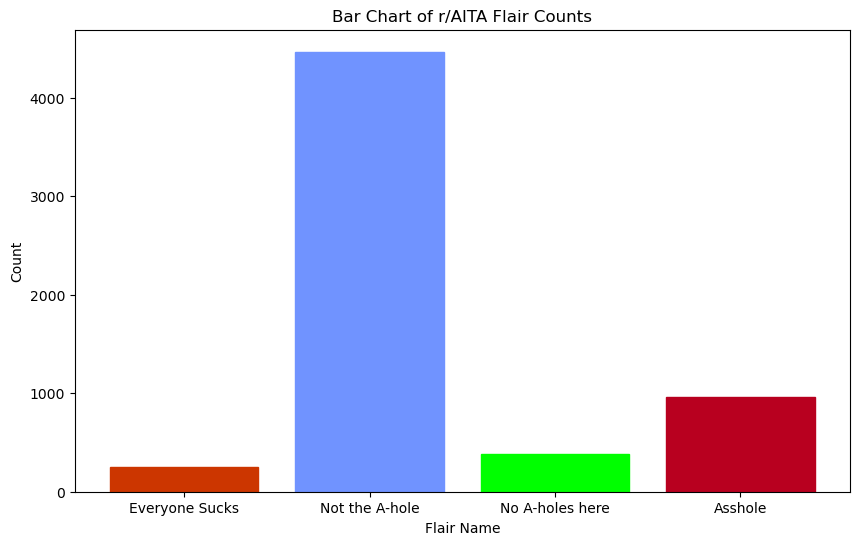

In [47]:
colors = ['#cc3600', '#7093ff', 'lime', '#b8001f']

plt.figure(figsize=(10, 6))
bars = plt.bar(df_flairs_viz["link_flair_text"], df_flairs_viz["count"])
for i in range(len(bars)):
    bars[i].set_color(colors[i])
plt.xlabel("Flair Name")
plt.ylabel("Count")
plt.title("Bar Chart of r/AITA Flair Counts")
plt.show()

To more accurately assess the proportion of each flair's presence, a treemap is plotted below:

Text(0.5, 1.0, 'Treemap of Flair Occurrence in r/AITA')

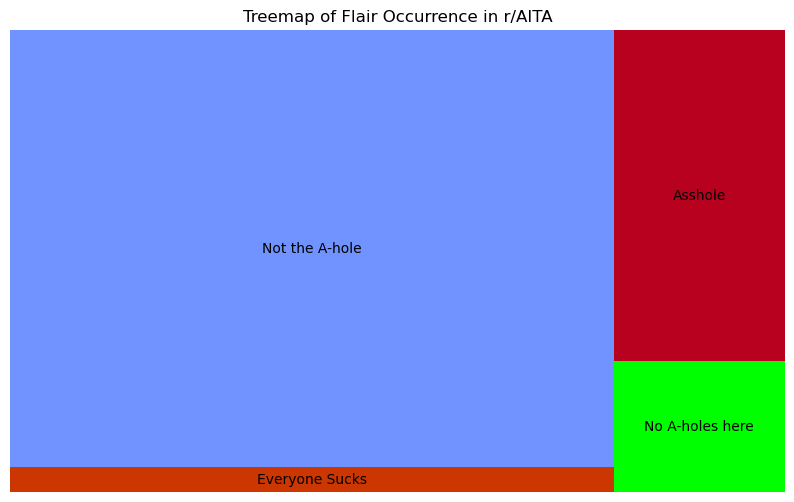

In [61]:
plt.figure(figsize = (10,6))
squarify.plot(sizes = df_flairs_viz['count'], color = colors, label = df_flairs_viz['link_flair_text'])
plt.axis('off')
plt.title("Treemap of Flair Occurrence in r/AITA")